In [1]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.6.4


In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = (150, 150)

tf.random.set_seed(0)

In [3]:
CLASSES = {'Cataract': 0, 'Diabetes': 1, 'Glaucoma': 2, 'Normal': 3, 'Other': 4}


In [4]:
def shuffle_prune(df, BATCH_SIZE):
    df = shuffle(df, random_state=42)
    df.reset_index(drop=True, inplace=True)
    df = df[ : df.shape[0] // BATCH_SIZE * BATCH_SIZE]
    return df

In [5]:
filenames = tf.io.gfile.glob('../input/eyeeye/ocular/Train/*/*.jpg')
image_path_df_train = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})
image_path_df_train = shuffle_prune(image_path_df_train, BATCH_SIZE)
image_path_df_train['class'] = image_path_df_train['class'].map(CLASSES)

print('Train sample: ', len(image_path_df_train['class']), dict(image_path_df_train['class'].value_counts()))

Train sample:  6592 {1: 2119, 3: 2091, 4: 1585, 0: 401, 2: 396}


In [6]:
filenames = tf.io.gfile.glob('../input/eyeeye/ocular/Validation/*/*')
image_path_df_test = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))

Test sample:  1322 {'Diabetes': 424, 'Normal': 422, 'Other': 317, 'Cataract': 80, 'Glaucoma': 79}


In [7]:
image_path_df_test, image_path_df_val  = train_test_split(image_path_df_test, test_size=0.5, random_state=42, stratify=image_path_df_test['class'])
image_path_df_test = shuffle_prune(image_path_df_test, BATCH_SIZE)
image_path_df_test['class'] = image_path_df_test['class'].map(CLASSES)

image_path_df_val = shuffle_prune(image_path_df_val, BATCH_SIZE)
image_path_df_val['class'] = image_path_df_val['class'].map(CLASSES)

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))
print('Val  sample: ', len(image_path_df_val['class']), dict(image_path_df_val['class'].value_counts()))

Test sample:  640 {1: 208, 3: 203, 4: 155, 2: 38, 0: 36}
Val  sample:  640 {3: 206, 1: 205, 4: 155, 2: 38, 0: 36}


In [8]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        image = cv2.imread(file)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
    images = np.array(images)
    
    labels = df.loc[:, 'class']
    return images, labels

In [9]:
train_images, train_labels = get_images_and_labels_arrays(image_path_df_train)

print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train set: {train_labels.shape}')

Shape of train set: (6592, 150, 150, 3)
Shape of train set: (6592,)


In [10]:
val_images, val_labels = get_images_and_labels_arrays(image_path_df_val)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation set: {val_labels.shape}')

Shape of validation set: (640, 150, 150, 3)
Shape of validation set: (640,)


In [11]:
test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test set: {test_labels.shape}')

Shape of test set: (640, 150, 150, 3)
Shape of test set: (640,)


In [12]:
def create_model():
    with tf.device('/gpu:0'):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False

        
        
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        
        x = pretrained_model(input_layer)

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)       
        x = layers.Dense(256,activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(128, activation='relu')(x)
        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        return model

model = create_model()
model.summary()

2022-08-06 12:30:26.192909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 12:30:26.311328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 12:30:26.312228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 12:30:26.316384: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
______________________________________________________________

In [13]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=50,
                    callbacks=[learning_rate_reduction, early_stopping],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

2022-08-06 12:30:31.015128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-06 12:30:32.826211: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


206/206 [==============================] - 17s 44ms/step - loss: 1.4189 - accuracy: 0.3794 - val_loss: 1.1218 - val_accuracy: 0.5406
Epoch 2/50
206/206 [==============================] - 9s 42ms/step - loss: 1.1317 - accuracy: 0.4967 - val_loss: 0.9710 - val_accuracy: 0.5938
Epoch 3/50
206/206 [==============================] - 9s 45ms/step - loss: 1.0165 - accuracy: 0.5583 - val_loss: 0.8809 - val_accuracy: 0.6359
Epoch 4/50
206/206 [==============================] - 9s 42ms/step - loss: 0.9263 - accuracy: 0.6073 - val_loss: 0.7598 - val_accuracy: 0.6984
Epoch 5/50
206/206 [==============================] - 9s 45ms/step - loss: 0.8589 - accuracy: 0.6371 - val_loss: 0.7183 - val_accuracy: 0.7172
Epoch 6/50
206/206 [==============================] - 9s 45ms/step - loss: 0.7723 - accuracy: 0.6817 - val_loss: 0.6387 - val_accuracy: 0.7359
Epoch 7/50
206/206 [==============================] - 9s 42ms/step - loss: 0.7096 - accuracy: 0.7033 - val_loss: 0.6102 - val_accuracy: 0.7563
Epoch 8/5

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.8843749761581421   loss:  0.2709566652774811


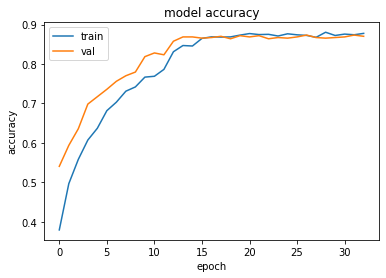

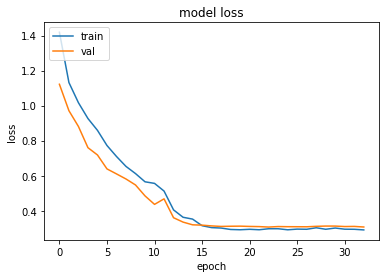

In [15]:
def plot(wut):
    plt.plot(trained.history[f'{wut}'])
    plt.plot(trained.history[f'val_{wut}'])
    plt.title(f'model {wut}')
    plt.ylabel(f'{wut}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot('accuracy')
plot('loss')

Classification Report


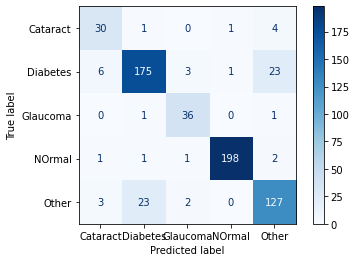

              precision    recall  f1-score   support

    Cataract       0.75      0.83      0.79        36
    Diabetes       0.87      0.84      0.86       208
    Glaucoma       0.86      0.95      0.90        38
      NOrmal       0.99      0.98      0.98       203
       Other       0.81      0.82      0.81       155

    accuracy                           0.88       640
   macro avg       0.86      0.88      0.87       640
weighted avg       0.89      0.88      0.88       640



In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(test_images)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
print('Classification Report')
target_names = ['Cataract', 'Diabetes', 'Glaucoma', 'NOrmal', 'Other']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(test_labels, y_pred, labels=[0,1,2,3,4], target_names=target_names))

In [17]:
model.save("final.h5")

In [18]:
model.save_weights("final_weights.h5")